In [1]:
# ! git clone https://github.com/CodeArchitecture/FinRL.git

In [2]:
# import os
# os.chdir('/kaggle/working/FinRL')
# print(os.getcwd())

In [3]:
# ! pip install -r requirements.txt

In [4]:
from IPython.display import clear_output
clear_output(wait=True)

In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor
from finrl.plot import backtest_stats, get_baseline
import itertools
from datetime import timedelta 
from datetime import datetime
from finrl.config_tickers import DOW_30_TICKER, SSE_50_TICKER, HSI_50_TICKER, DAX_30_TICKER
from finrl.main import clean_and_make_directories
from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR, INDICATORS

d:\Anaconda\envs\fin\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [6]:
clean_and_make_directories([TRAINED_MODEL_DIR, RESULTS_DIR, os.path.join(RESULTS_DIR,'a2c'),
                            os.path.join(RESULTS_DIR,'ddpg'),os.path.join(RESULTS_DIR,'ppo'),
                            os.path.join(RESULTS_DIR,'td3'),os.path.join(RESULTS_DIR,'sac')])

In [7]:
TRAIN_START_DATE = '2012-01-01'
TRAIN_END_DATE = '2022-01-01'
TRADE_START_DATE = '2022-01-01'
TRADE_END_DATE = '2023-01-01'

TIMESTEPS = [100,100,100,100,100]
# TIMESTEPS = [20000,20000,20000,20000,20000]

# '^DJI','^SSE','^HSI', '^GDAXI'
# DOW_30_TICKER, SSE_50_TICKER, HSI_50_TICKER, DAX_30_TICKER
DATA_NAME = 'DAX'
PORTFOLIO = DAX_30_TICKER
BASELINES = '^GDAXI'

In [8]:
L=400
# download more date to compute tech indicator like macd
date = datetime.strptime(TRAIN_START_DATE, "%Y-%m-%d")
date = date - timedelta(days=L)
datetime.strftime(date, "%Y-%m-%d")
df = YahooDownloader(start_date = date,
                     end_date = TRADE_END_DATE,
                     ticker_list = PORTFOLIO).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- DAI.DE: No timezone found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*****

In [9]:
print(PORTFOLIO)

['DHER.DE', 'RWE.DE', 'FRE.DE', 'MTX.DE', 'MRK.DE', 'LIN.DE', 'ALV.DE', 'VNA.DE', 'EOAN.DE', 'HEN3.DE', 'DAI.DE', 'DB1.DE', 'DPW.DE', 'DWNI.DE', 'BMW.DE', 'DTE.DE', 'VOW3.DE', 'MUV2.DE', '1COV.DE', 'SAP.DE', 'FME.DE', 'BAS.DE', 'BAYN.DE', 'BEI.DE', 'CON.DE', 'SIE.DE', 'ADS.DE', 'HEI.DE', 'DBK.DE', 'IFX.DE']


In [10]:
df.shape

(85436, 8)

In [11]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2010-11-29,48.915001,49.250000,48.055000,39.327408,954565,ADS.DE,0
1,2010-11-29,87.250000,88.510002,85.309998,48.756535,3163118,ALV.DE,0
2,2010-11-29,58.400002,59.130001,56.290001,31.418045,4159196,BAS.DE,0
3,2010-11-29,56.664192,57.028309,55.168369,37.720058,2833724,BAYN.DE,0
4,2010-11-29,45.665001,45.865002,44.625000,38.634972,590062,BEI.DE,0


In [12]:
df.tic.value_counts()

ADS.DE     3069
ALV.DE     3069
VOW3.DE    3069
SIE.DE     3069
SAP.DE     3069
RWE.DE     3069
MUV2.DE    3069
MTX.DE     3069
MRK.DE     3069
LIN.DE     3069
IFX.DE     3069
HEN3.DE    3069
HEI.DE     3069
FRE.DE     3069
FME.DE     3069
EOAN.DE    3069
DWNI.DE    3069
DTE.DE     3069
DPW.DE     3069
DBK.DE     3069
DB1.DE     3069
CON.DE     3069
BMW.DE     3069
BEI.DE     3069
BAYN.DE    3069
BAS.DE     3069
VNA.DE     2404
1COV.DE    1840
DHER.DE    1398
Name: tic, dtype: int64

In [13]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3043, 8)
Successfully added vix
Successfully added turbulence index


In [14]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [15]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-11-29,ADS.DE,48.915001,49.250000,48.055000,39.327408,954565.0,0.0,0.0,39.600815,39.196831,100.0,-66.666667,100.0,39.327408,39.327408,21.530001,0.0
1,2010-11-29,ALV.DE,87.250000,88.510002,85.309998,48.756535,3163118.0,0.0,0.0,39.600815,39.196831,100.0,-66.666667,100.0,48.756535,48.756535,21.530001,0.0
2,2010-11-29,BAS.DE,58.400002,59.130001,56.290001,31.418045,4159196.0,0.0,0.0,39.600815,39.196831,100.0,-66.666667,100.0,31.418045,31.418045,21.530001,0.0
3,2010-11-29,BAYN.DE,56.664192,57.028309,55.168369,37.720058,2833724.0,0.0,0.0,39.600815,39.196831,100.0,-66.666667,100.0,37.720058,37.720058,21.530001,0.0
4,2010-11-29,BEI.DE,45.665001,45.865002,44.625000,38.634972,590062.0,0.0,0.0,39.600815,39.196831,100.0,-66.666667,100.0,38.634972,38.634972,21.530001,0.0
5,2010-11-29,BMW.DE,59.750000,59.910000,57.740002,34.999832,2266241.0,0.0,0.0,39.600815,39.196831,100.0,-66.666667,100.0,34.999832,34.999832,21.530001,0.0
6,2010-11-29,CON.DE,60.500000,60.860001,57.939999,42.630630,258634.0,0.0,0.0,39.600815,39.196831,100.0,-66.666667,100.0,42.630630,42.630630,21.530001,0.0
7,2010-11-29,DB1.DE,48.529999,48.869999,47.150002,33.872952,1403606.0,0.0,0.0,39.600815,39.196831,100.0,-66.666667,100.0,33.872952,33.872952,21.530001,0.0
8,2010-11-29,DBK.DE,33.003269,33.182034,31.070913,26.477226,18033304.0,0.0,0.0,39.600815,39.196831,100.0,-66.666667,100.0,26.477226,26.477226,21.530001,0.0
9,2010-11-29,DPW.DE,12.965000,12.970000,12.550000,7.847433,6840371.0,0.0,0.0,39.600815,39.196831,100.0,-66.666667,100.0,7.847433,7.847433,21.530001,0.0


In [16]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

64168
6474


In [17]:
train.head(2)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2012-01-03,ADS.DE,51.560001,52.41,51.560001,43.200539,748556.0,1.0,0.251034,43.175744,39.136064,55.678776,148.479805,21.870715,41.246163,41.590146,22.969999,32.380217
0,2012-01-03,ALV.DE,77.669998,78.50,76.889999,46.480877,2141758.0,1.0,0.213381,47.885233,41.810910,53.203979,75.837795,22.278503,44.216279,44.971710,22.969999,32.380217


In [18]:
train.tail(2)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2467,2021-12-30,SIE.DE,151.179993,152.679993,150.940002,144.23616,881579.0,3.0,0.848588,145.349711,136.946189,55.329504,53.841817,8.839434,141.456866,138.231674,17.33,9.264083
2467,2021-12-30,VOW3.DE,177.000000,177.479996,176.500000,144.82164,333679.0,3.0,-0.462810,152.950528,135.312093,46.952630,18.765242,5.290736,143.010144,149.833849,17.33,9.264083


In [19]:
trade.head(2)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2022-01-03,ADS.DE,254.350006,260.149994,253.949997,254.362473,488053.0,0.0,-3.268779,256.855007,240.010810,46.321240,3.384360,1.947942,252.353226,263.241267,16.6,36.61891
0,2022-01-03,ALV.DE,208.050003,211.000000,207.949997,199.237122,766707.0,0.0,1.903095,199.845043,188.420962,58.350189,149.798714,22.943693,192.306307,191.719879,16.6,36.61891


In [20]:
trade.tail(2)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
248,2022-12-29,SIE.DE,127.900002,130.460007,127.800003,126.729851,637451.0,3.0,0.858124,133.045031,121.877833,57.987612,-51.838373,3.174942,127.444269,117.698908,21.440001,5.448229
248,2022-12-29,VOW3.DE,114.959999,116.900002,114.300003,116.139999,645867.0,3.0,-0.527243,122.262497,113.745427,48.457975,-148.808314,47.485807,118.349569,115.794169,21.440001,5.448229


In [21]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [22]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 26, State Space: 261


In [23]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [24]:
env_train, _ = StockTradingEnv(df = train, **env_kwargs).get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [25]:
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [26]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

trained_a2c = agent.train_model(model=model_a2c, 
                             total_timesteps=TIMESTEPS[0]) if if_using_a2c else None

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


### Agent 2: DDPG

In [27]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

trained_ddpg = agent.train_model(model=model_ddpg, 
                             total_timesteps=TIMESTEPS[1]) if if_using_ddpg else None

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


### Agent 3: PPO

In [28]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

trained_ppo = agent.train_model(model=model_ppo, 
                             total_timesteps=TIMESTEPS[2]) if if_using_ppo else None

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
-----------------------------------
| time/              |            |
|    fps             | 42         |
|    iterations      | 1          |
|    time_elapsed    | 48         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | -2.6987545 |
-----------------------------------


### Agent 4: TD3

In [29]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

trained_td3 = agent.train_model(model=model_td3, 
                             total_timesteps=TIMESTEPS[3]) if if_using_td3 else None

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


### Agent 5: SAC

In [30]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

trained_sac = agent.train_model(model=model_sac, 
                             total_timesteps=TIMESTEPS[4]) if if_using_sac else None

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


## In-sample Performance

In [31]:
insample_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)].drop_duplicates(subset=['date'])

count    2468.000000
mean       17.067127
std         6.812706
min         9.140000
25%        13.015000
50%        15.385000
75%        18.940001
max        82.690002
Name: vix, dtype: float64


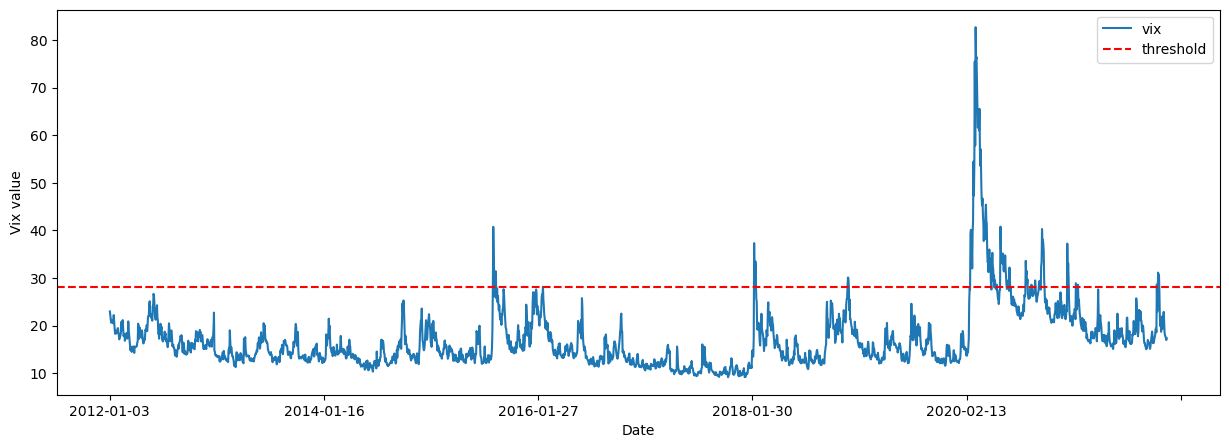

In [32]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
fig = insample_risk_indicator.set_index('date').vix.plot()
fig.axhline(y=insample_risk_indicator.vix.quantile(0.95), color='r', linestyle='--',label='threshold')
fig.set_xlabel('Date')
fig.set_ylabel('Vix value')
fig.legend()
fig.get_figure().savefig('results/train_vix.png')

print(insample_risk_indicator.vix.describe())
insample_risk_indicator.vix.describe().to_csv('results/train_vix_describe.csv')

count      2468.000000
mean        244.781801
std       10547.295047
min           0.081096
25%          14.774964
50%          22.913383
75%          35.722183
max      524007.295773
Name: turbulence, dtype: float64


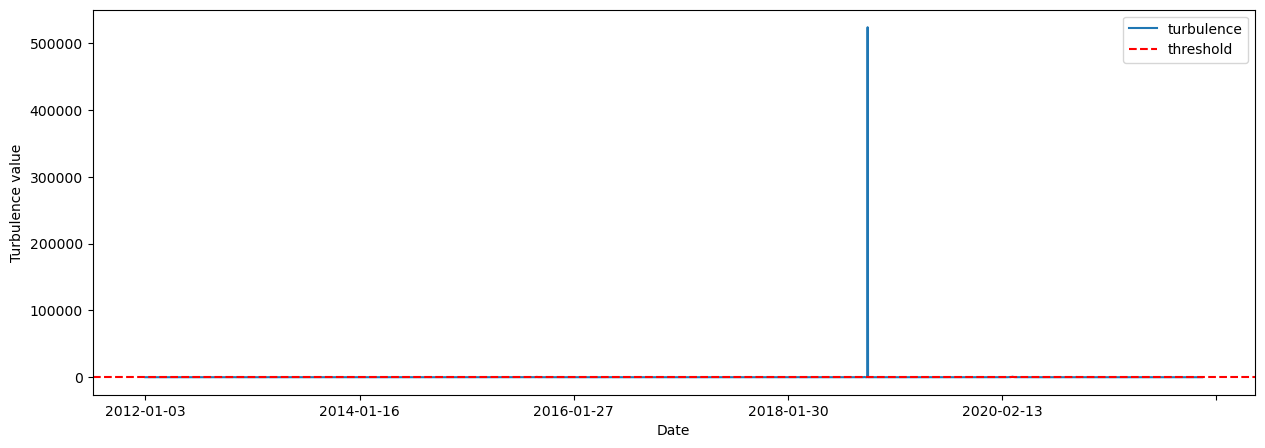

In [33]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
insample_risk_indicator.turbulence.describe()
fig = insample_risk_indicator.set_index('date').turbulence.plot()
fig.axhline(y=insample_risk_indicator.turbulence.quantile(0.95), color='r', linestyle='--',label='threshold')
fig.set_xlabel('Date')
fig.set_ylabel('Turbulence value')
fig.legend()
fig.get_figure().savefig('results/train_turbulence')

print(insample_risk_indicator.turbulence.describe())
insample_risk_indicator.turbulence.describe().to_csv('results/train_turbulence_describe.csv')

In [34]:
insample_risk_indicator = processed_full[(processed_full.date<TRADE_END_DATE) & (processed_full.date>=TRADE_START_DATE)].drop_duplicates(subset=['date'])

count    249.000000
mean      25.653655
std        4.219056
min       16.600000
25%       22.290001
50%       25.540001
75%       28.950001
max       36.450001
Name: vix, dtype: float64


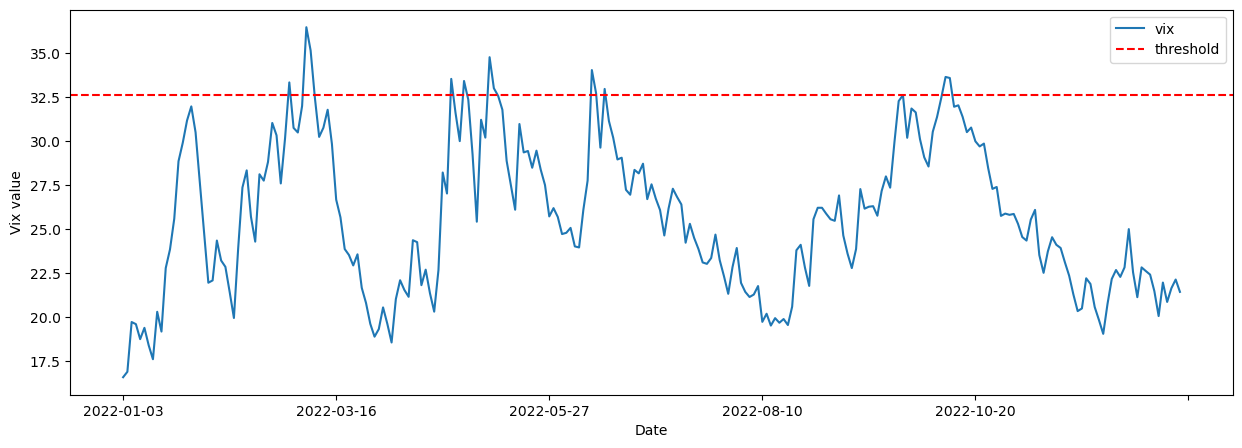

In [35]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
fig = insample_risk_indicator.set_index('date').vix.plot()
fig.axhline(y=insample_risk_indicator.vix.quantile(0.95), color='r', linestyle='--',label='threshold')
fig.set_xlabel('Date')
fig.set_ylabel('Vix value')
fig.legend()
fig.get_figure().savefig('results/trade_vix.png')

print(insample_risk_indicator.vix.describe())
insample_risk_indicator.vix.describe().to_csv('results/trade_vix_describe.csv')

count    249.000000
mean      38.953532
std       35.629303
min        0.108666
25%       18.433977
50%       27.840446
75%       43.988834
max      274.978280
Name: turbulence, dtype: float64


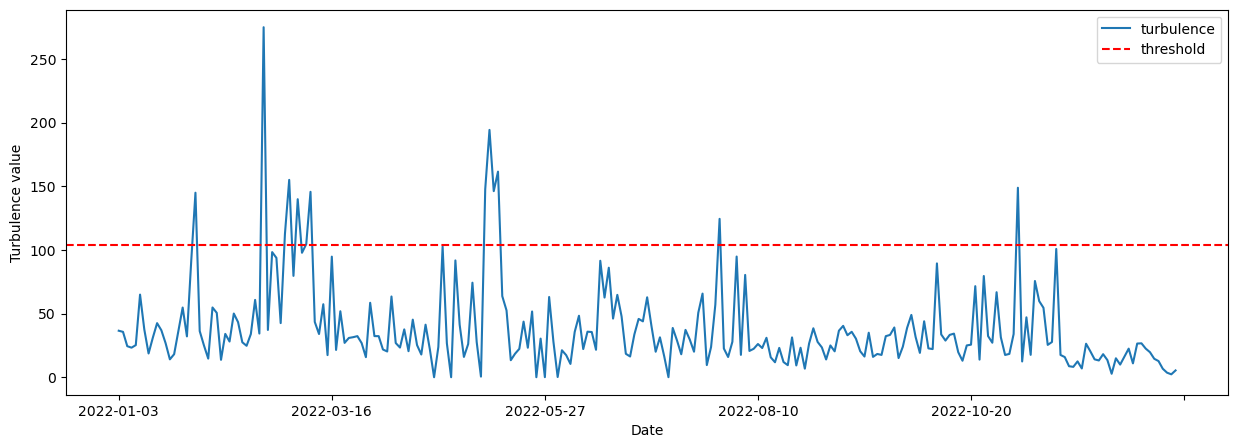

In [36]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
insample_risk_indicator.turbulence.describe()
fig = insample_risk_indicator.set_index('date').turbulence.plot()
fig.axhline(y=insample_risk_indicator.turbulence.quantile(0.95), color='r', linestyle='--',label='threshold')
fig.set_xlabel('Date')
fig.set_ylabel('Turbulence value')
fig.legend()
fig.get_figure().savefig('results/trade_turbulence')

print(insample_risk_indicator.turbulence.describe())
insample_risk_indicator.turbulence.describe().to_csv('results/trade_turbulence_describe.csv')

In [37]:
model_list = {'a2c':trained_a2c,'ddpg':trained_ddpg,'ppo':trained_ppo,'sac':trained_sac,'td3':trained_td3}
model_name_list = ['a2c','ddpg','ppo','sac','td3']
for i, model_name in enumerate(model_name_list):
    for j, vix_quantile in enumerate([0.8,0.85,0.9,0.95]):
        e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = insample_risk_indicator.vix.quantile(vix_quantile),risk_indicator_col='vix', **env_kwargs)
        trained_model = model_list[model_name]
        df_account_value, df_actions = DRLAgent.DRL_prediction(model=trained_model, environment = e_trade_gym)
        df_account_value.set_index(df_account_value.columns[0]).to_csv('results/{}/df_account_value_vix{}'.format(model_name,int(vix_quantile*100)))
        df_actions.to_csv('results/{}/df_actions_vix{}'.format(model_name,int(vix_quantile*100)))
    for j, turbulence_quantile in enumerate([0.8,0.85,0.9,0.95]):
        e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = insample_risk_indicator.turbulence.quantile(turbulence_quantile),risk_indicator_col='vix', **env_kwargs)
        trained_model = model_list[model_name]
        df_account_value, df_actions = DRLAgent.DRL_prediction(model=trained_model, environment = e_trade_gym)
        df_account_value.set_index(df_account_value.columns[0]).to_csv('results/{}/df_account_value_turbulence{}'.format(model_name,int(turbulence_quantile*100)))
        df_actions.to_csv('results/{}/df_actions_turbulence{}'.format(model_name,int(turbulence_quantile*100)))

In [38]:
# BASELINES = '^SSE'
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(ticker=BASELINES, start = TRADE_START_DATE, end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = pd.read_csv('results/a2c/df_account_value_turbulence80')['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("results/df_{}.csv".format(DATA_NAME))

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (257, 8)


d:\Anaconda\envs\fin\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


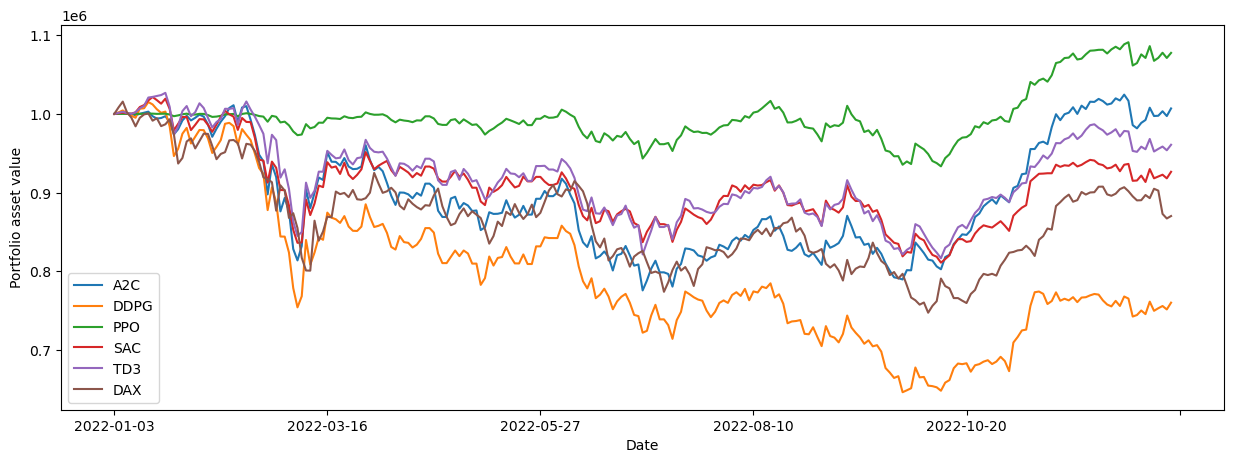

In [39]:
%matplotlib inline
df1 = pd.read_csv('results/a2c/df_account_value_turbulence90',index_col=0)
df2 = pd.read_csv('results/ddpg/df_account_value_turbulence90',index_col=0)
df3 = pd.read_csv('results/ppo/df_account_value_turbulence90',index_col=0)
df4 = pd.read_csv('results/sac/df_account_value_turbulence90',index_col=0)
df5 = pd.read_csv('results/td3/df_account_value_turbulence90',index_col=0)
df6 = pd.read_csv('results/df_{}.csv'.format(DATA_NAME),index_col=0)

plt.rcParams["figure.figsize"] = (15,5)
df = pd.concat([df1,df2,df3,df4,df5,df6],axis=1)
df.columns=['A2C','DDPG','PPO','SAC','TD3', DATA_NAME]
fig = df.plot()
fig.set_xlabel('Date')
fig.set_ylabel('Portfolio asset value')
plt.legend()
fig.get_figure().savefig('results/backtest.png')

In [40]:
import shutil
folder_name = 'results'
zip_file_name = 'results'
shutil.make_archive(zip_file_name, 'zip', folder_name)

'c:\\Users\\ThinkPad\\Desktop\\code\\FinRL\\results.zip'

In [41]:
# pd.DataFrame(backtest_stats(account_value=df_account_value_a2c)).to_csv('results/a2c_perf.csv')
# pd.DataFrame(backtest_stats(account_value=df_account_value_ddpg)).to_csv('results/ddpg_perf.csv')
# pd.DataFrame(backtest_stats(account_value=df_account_value_td3)).to_csv('results/td3_perf.csv')
# pd.DataFrame(backtest_stats(account_value=df_account_value_ppo)).to_csv('results/ppo_perf.csv')
# pd.DataFrame(backtest_stats(account_value=df_account_value_sac)).to_csv('results/sac_perf.csv')